In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 21.7 MB/s eta 0:00:0000:01


# **SelfAttention Gamma corrected code on Natural Images**

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Dense, Flatten, RepeatVector, Permute, Multiply, Input, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import cv2

# Define the paths
train_dir = '/kaggle/input/mouth-and-oral-disease-mod-dataset/Mouth and Oral Disease (MOD) dataset/Training'
test_dir = '/kaggle/input/mouth-and-oral-disease-mod-dataset/Mouth and Oral Disease (MOD) dataset/Testing'
val_dir = '/kaggle/input/mouth-and-oral-disease-mod-dataset/Mouth and Oral Disease (MOD) dataset/Validation'

# Define parameters
img_size = (224, 224)  # EfficientNet expects images of size 224x224
batch_size = 64
gamma_value = 1.5
num_classes = 7 
learning_rate = 0.001
num_epochs = 10
num_runs = 10

# Function to apply gamma correction
def apply_gamma_correction(image):
    # Normalize to [0, 1] range
    image = image / 255.0
    # Apply gamma correction
    corrected_image = np.power(image, gamma_value)
    return (corrected_image * 255).astype(np.uint8)  # Scale back to [0, 255]

# Custom data generator to apply gamma correction
class GammaCorrectionDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, img_size):
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.class_names = np.array([item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))])
        self.image_paths = []
        self.labels = []

        for idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(directory, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(idx)

        self.labels = tf.keras.utils.to_categorical(self.labels, num_classes=len(self.class_names))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_image_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        for path in batch_image_paths:
            image = cv2.imread(path)
            image = cv2.resize(image, self.img_size)
            image = apply_gamma_correction(image)
            images.append(image)
        
        return np.array(images), np.array(batch_labels)


# Create data generators
train_generator = GammaCorrectionDataGenerator(train_dir, batch_size, img_size)
validation_generator = GammaCorrectionDataGenerator(val_dir, batch_size, img_size)
test_generator = GammaCorrectionDataGenerator(test_dir, batch_size, img_size)

class_names = np.array([item for item in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, item))])
# class_names = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
print(class_names)

# Calculate the total number of images in each dataset
def get_total_images(generator, dataset_name):
    total_images = len(generator.image_paths)
    print(f"Total images in {dataset_name}: {total_images}")
    return total_images

# Print total images in train, validation, and test directories
total_train_images = get_total_images(train_generator, "Training set")
total_val_images = get_total_images(validation_generator, "Validation set")
total_test_images = get_total_images(test_generator, "Test set")

# Define the self-attention block
class NovelSelfAttentionBlock(Layer):
    def __init__(self, units=128):
        super(NovelSelfAttentionBlock, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        self.dense = Dense(self.units, activation='relu')
        self.flatten = Flatten()
        self.softmax = tf.keras.layers.Softmax()
        self.repeat_vector = RepeatVector(input_shape[1])
        self.permute = Permute((2, 1))
        self.multiply = Multiply()
    
    def call(self, inputs):
        # Compute attention weights
        Z = self.dense(inputs)
        flattened_Z = self.flatten(Z)
        attention_weights = self.softmax(flattened_Z)
        
        # Modify attention weights
        repeated_attention_weights = self.repeat_vector(attention_weights)
        permuted_attention_weights = self.permute(repeated_attention_weights)
        
        # Apply attention weights to the input tensor
        attended_output = self.multiply([inputs, permuted_attention_weights])
        
        return attended_output

def create_model(base_model0, base_model1, num_classes):
    input_tensor = Input(shape=input_shape)
    
    # Process with base models
    conv0 = base_model0(input_tensor)
    conv0 = GlobalAveragePooling2D()(conv0)
    
    conv1 = base_model1(input_tensor)
    conv1 = GlobalAveragePooling2D()(conv1)
    
    # Concatenate features
    concatenated_features = Concatenate()([conv0, conv1])
    
    # Apply self-attention block
    attention_output = NovelSelfAttentionBlock()(concatenated_features)
    
    # Flatten the output from the attention block
    flattened_output = Flatten()(attention_output)
    
    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(flattened_output)

    model = Model(inputs=input_tensor, outputs=output_layer)
    return model

# Define paths and parameters
input_shape = (224, 224, 3)
base_model0 = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
base_model1 = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model0.layers:
    layer.trainable = False

for layer in base_model1.layers:
    layer.trainable = False

def train_model(base_model0, base_model1, num_classes):
    model = create_model(base_model0, base_model1, num_classes)
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'best_model.keras', save_best_only=True)  # Use .keras extension
    ]


    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    model.save('best_model.h5')
    return model, history

['OC' 'CaS' 'OT' 'CoS' 'Gum' 'MC' 'OLP']
Total images in Training set: 3087
Total images in Validation set: 1028
Total images in Test set: 1028
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
trained_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_5[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb1      │ (None, 7, 7,      │  6,575,239 │ input_layer_5[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb1[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ novel_self_attenti… │ (None, 128, 2560) │    327,808 │ concatenate_1[0]… │
│ (NovelSelfAttentio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 327680)    │          0 │ novel_self_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │  2,293,767 │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,489,537 (70.53 MB)

 Trainable params: 2,621,575 (10.00 MB)

 Non-trainable params: 10,624,810 (40.53 MB)

 Optimizer params: 5,243,152 (20.00 MB)

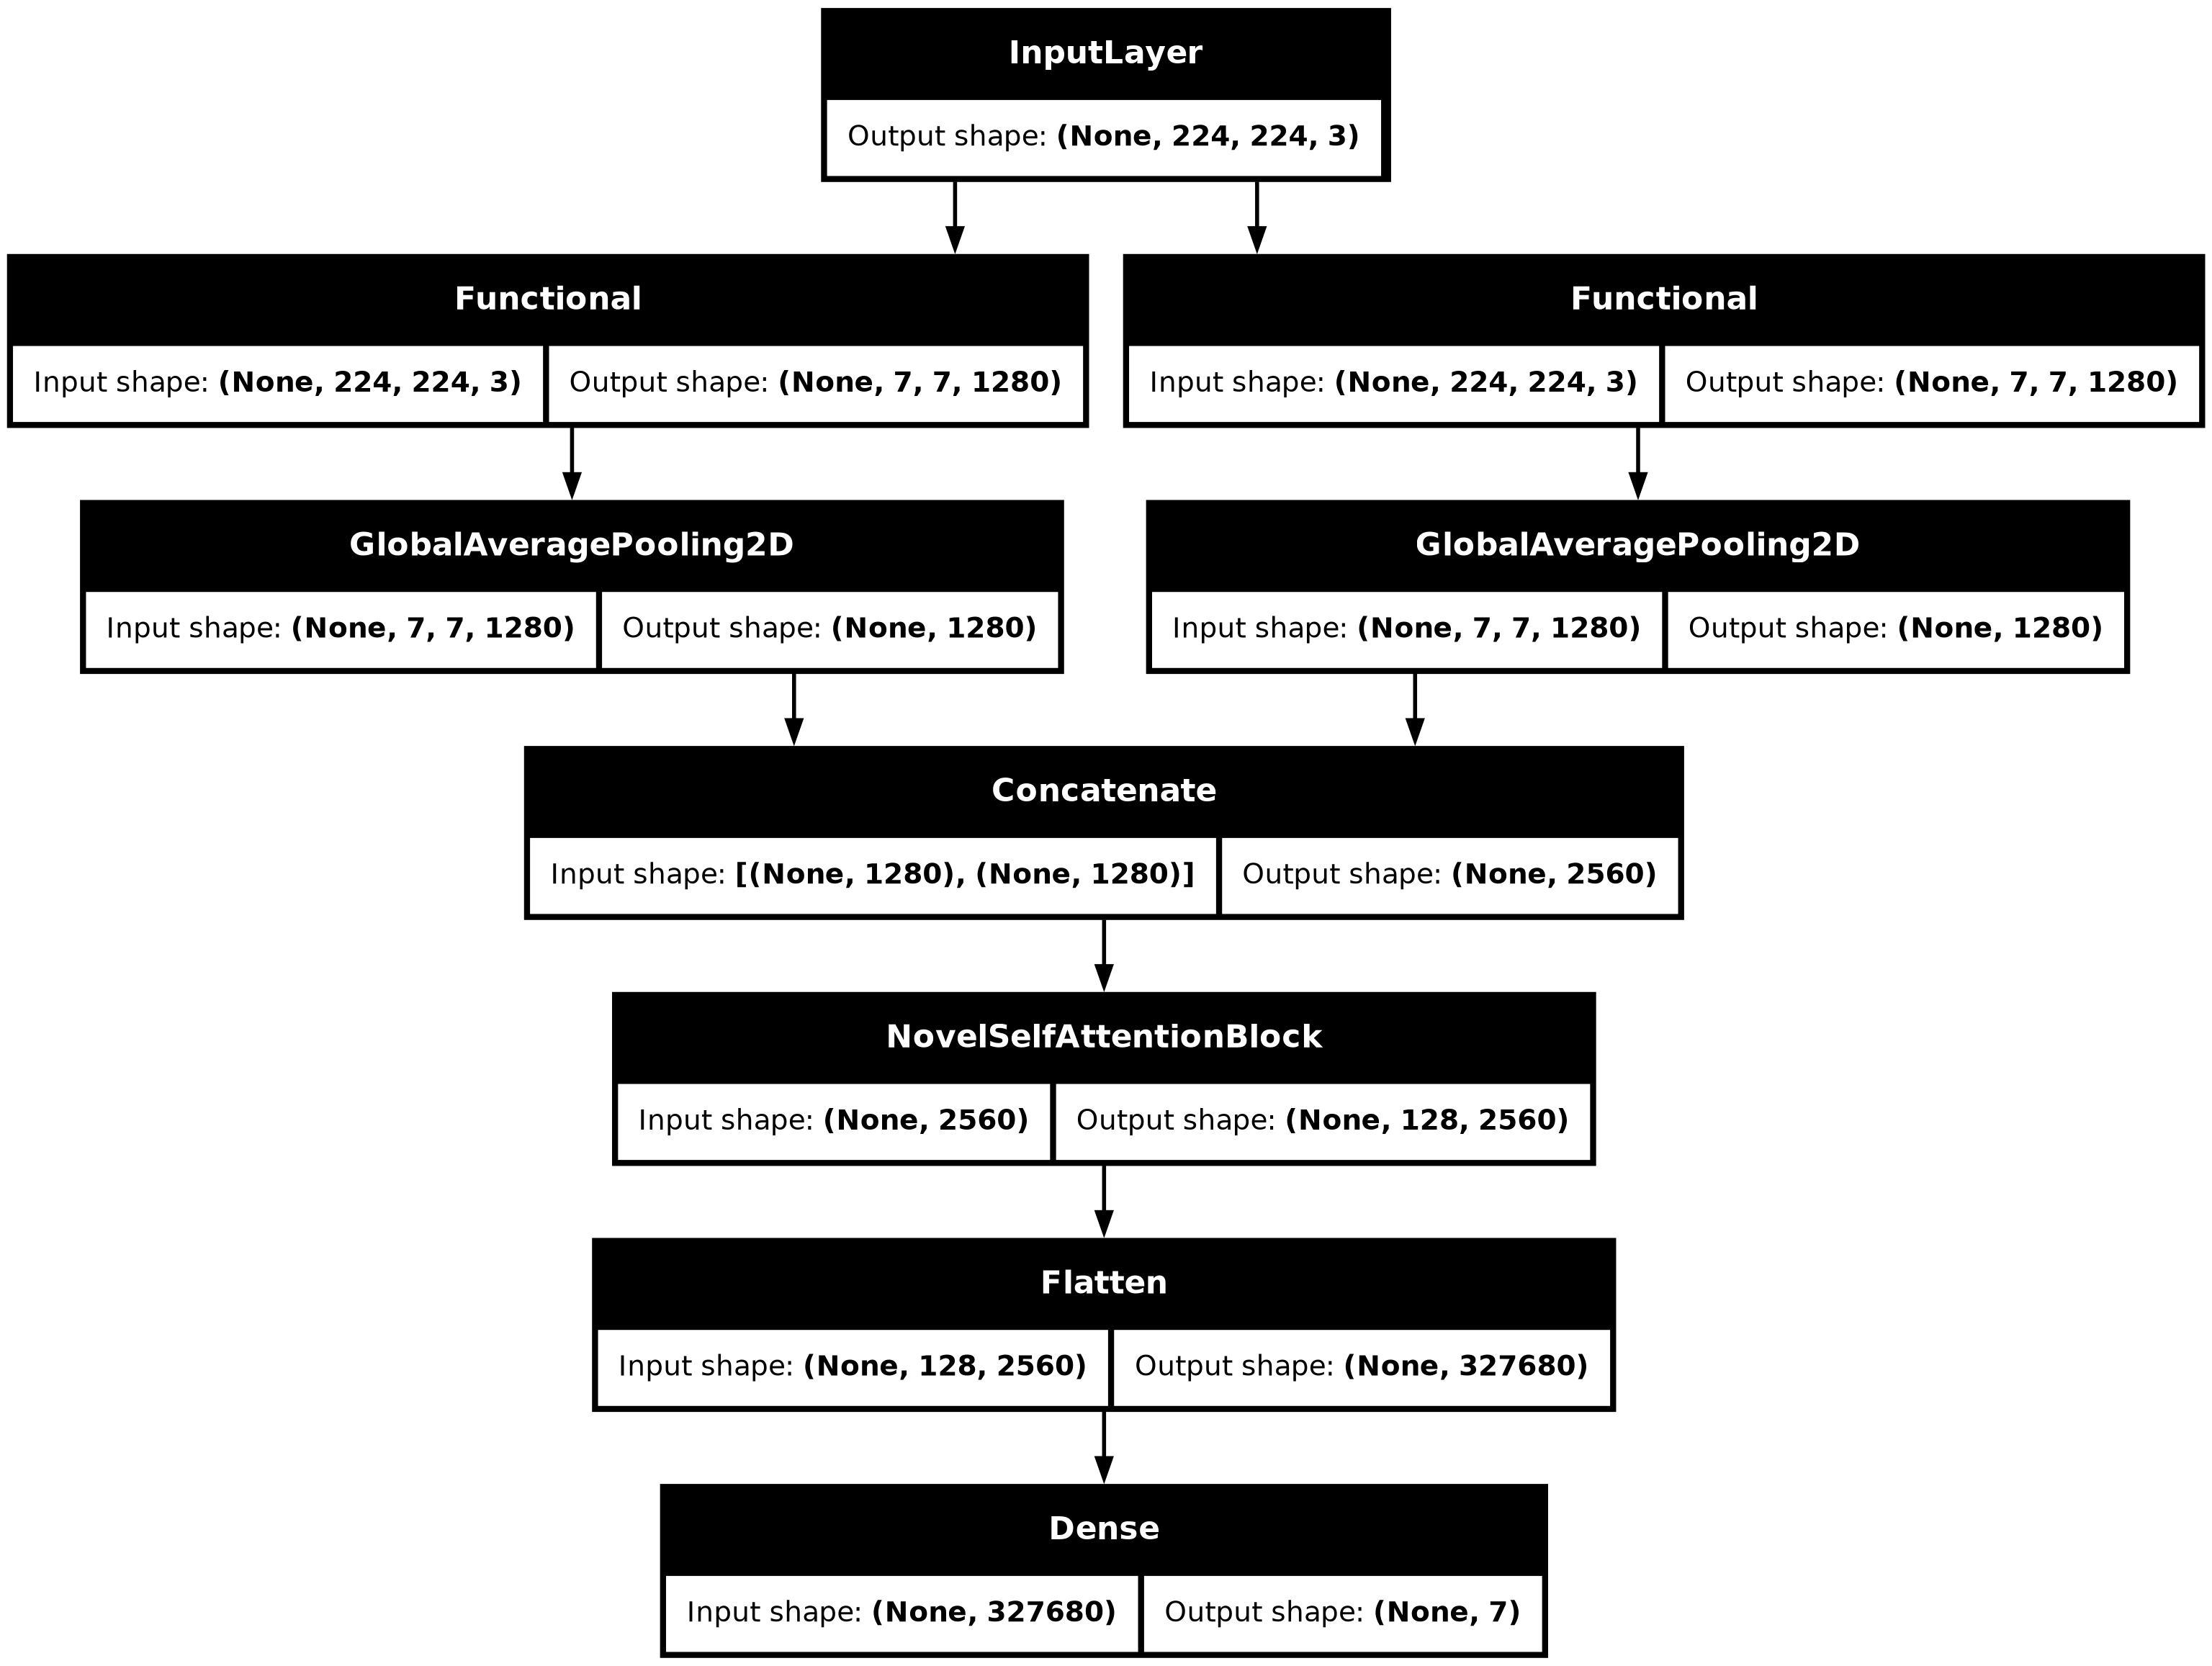

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(trained_model, show_shapes=True, show_layer_names=False)

plot_model(trained_model, to_file=filename, show_shapes=True, show_layer_names=True)
    print(f"Model diagram saved as '{filename}'.")

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


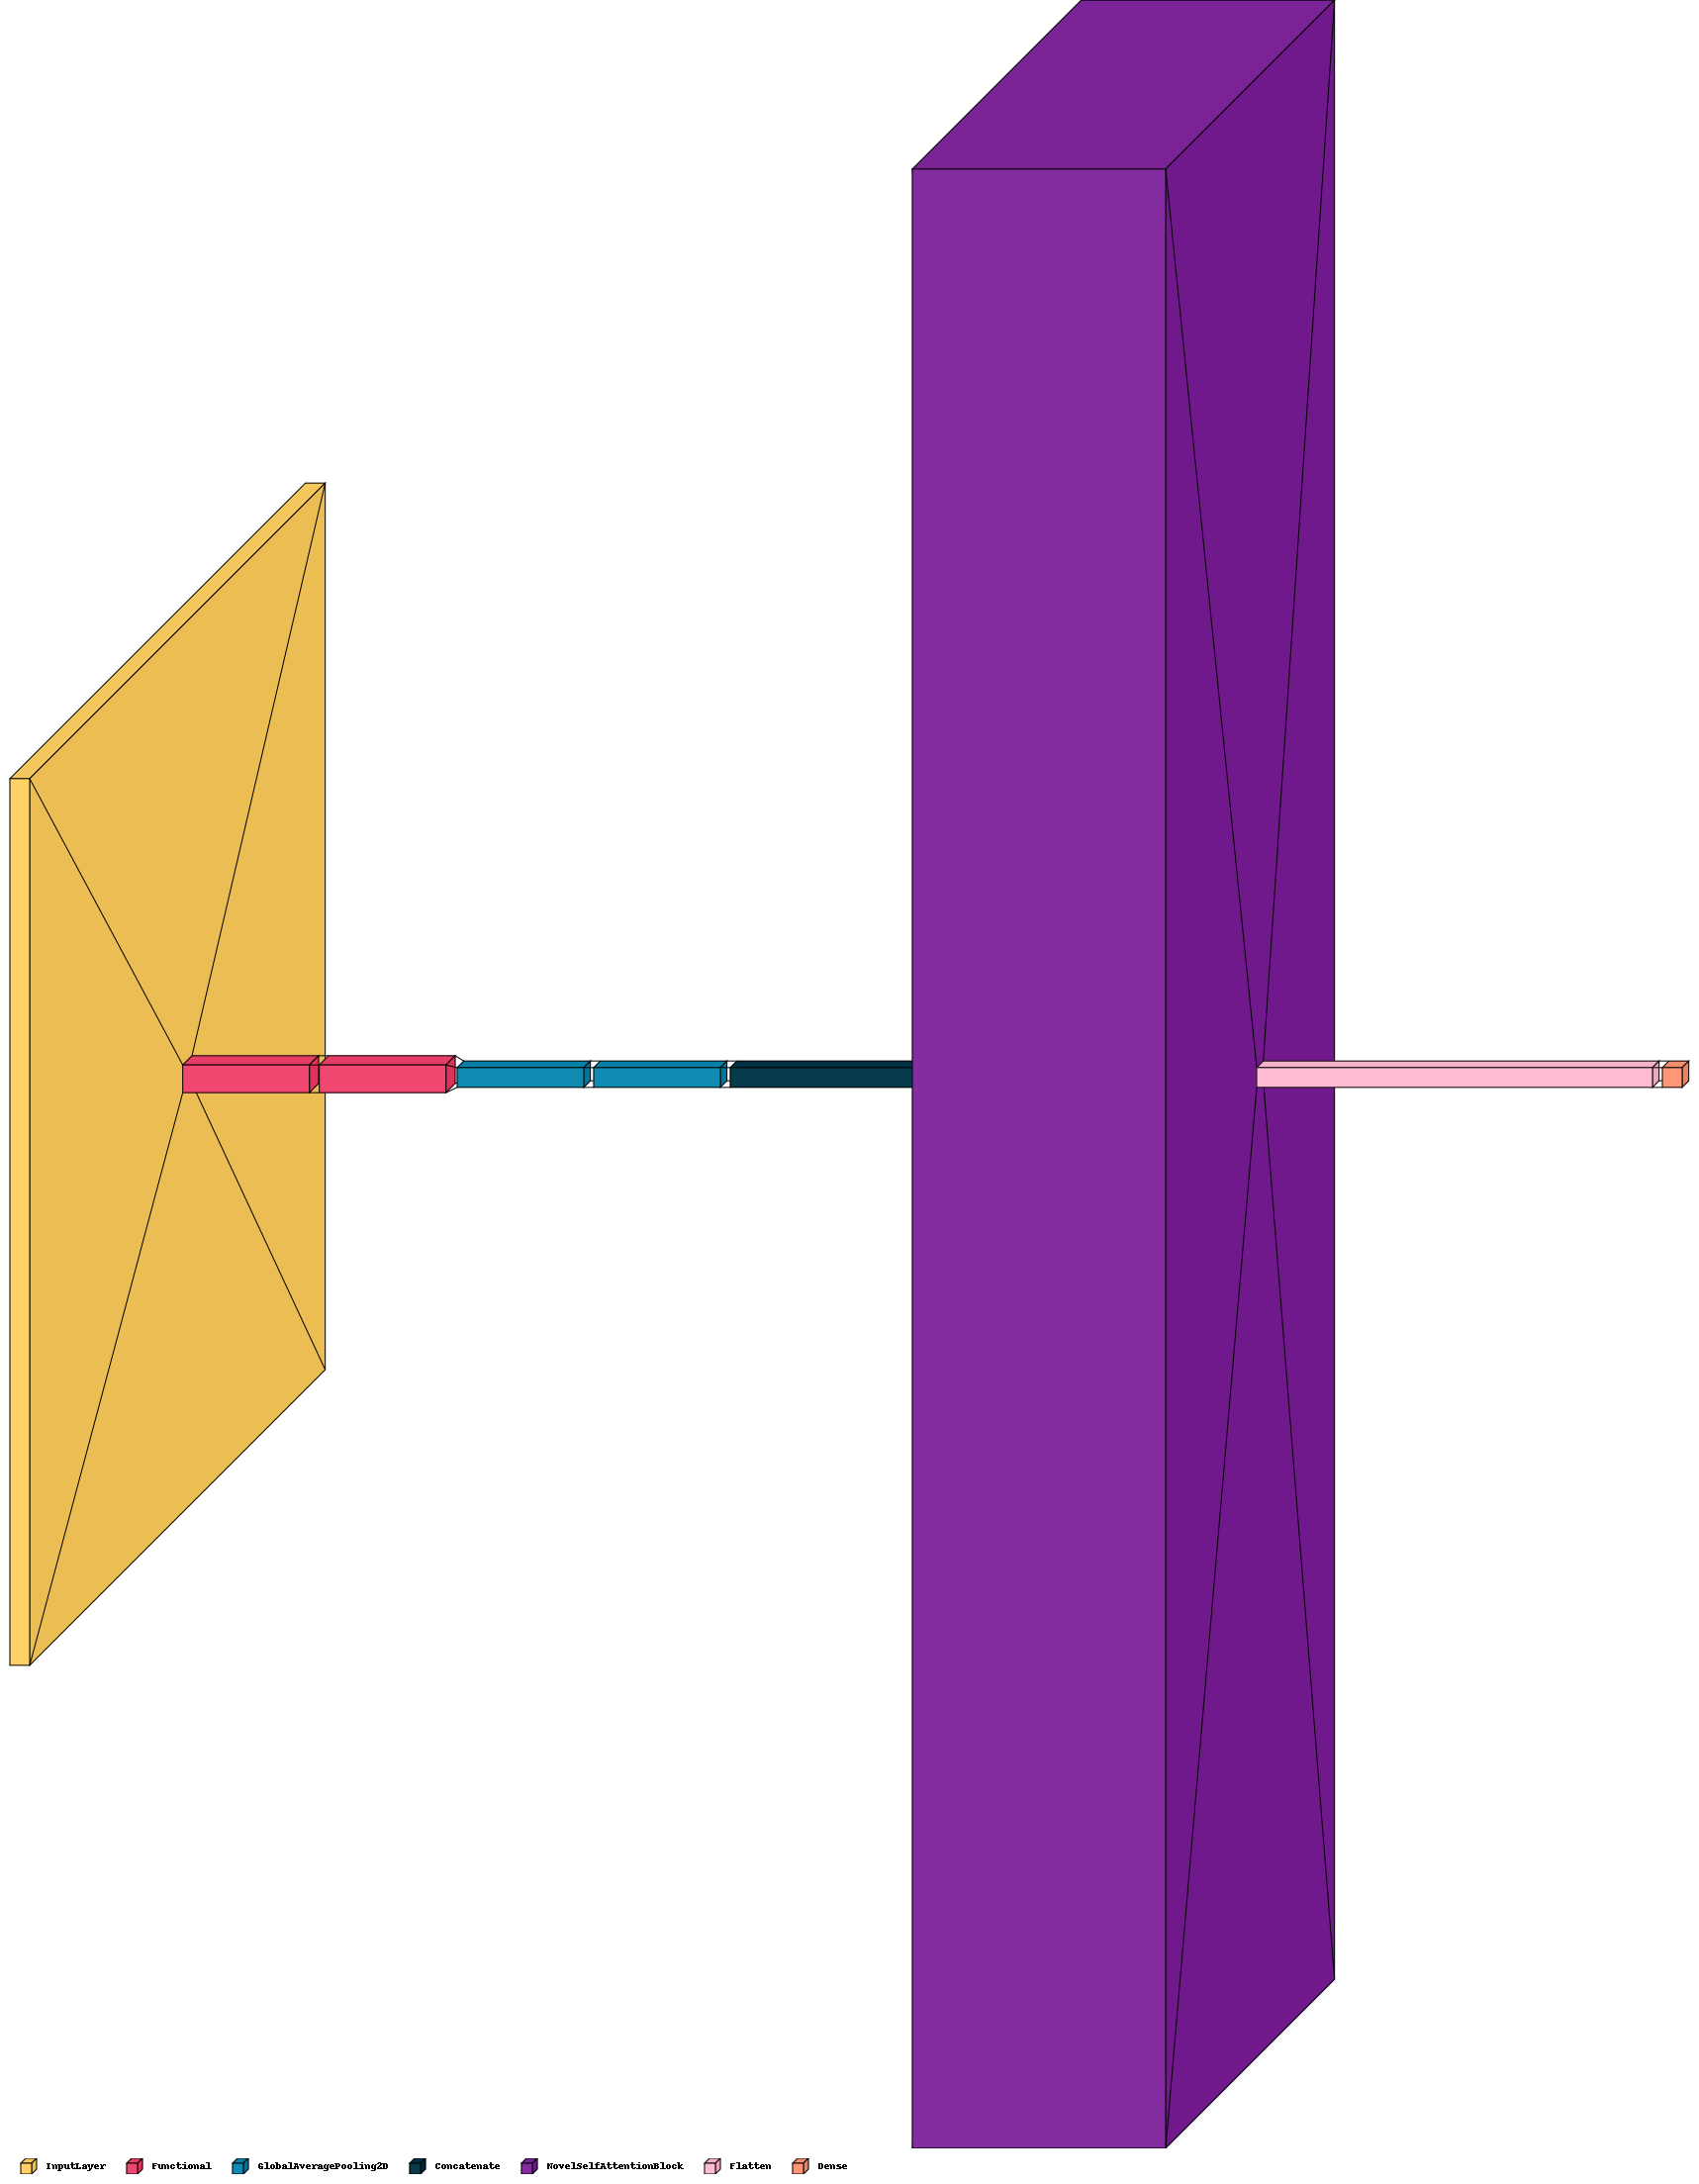

In [7]:
import visualkeras

visualkeras.layered_view(trained_model, legend=True)

# **Code to Display some gamma corected images**

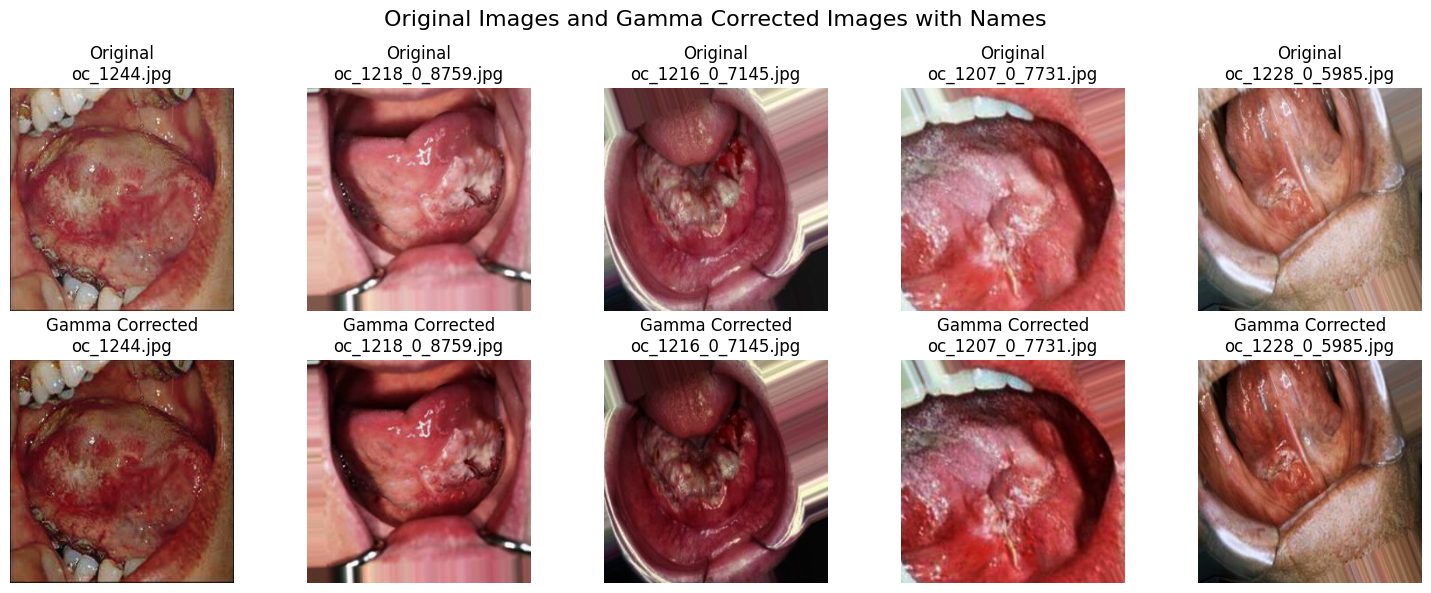

In [2]:
import matplotlib.pyplot as plt

# Function to plot original and gamma-corrected images from the test generator
def plot_images_with_names(generator, num_images=5):
    # Get the first batch of images and their labels
    images, labels = generator[0]
    image_paths = generator.image_paths[:num_images]  # First 5 image paths
    
    # Create a figure to plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle("Original Images and Gamma Corrected Images with Names", fontsize=16)
    
    for i in range(num_images):
        # Read the original image using the file path
        original_image = cv2.imread(image_paths[i])
        original_image = cv2.resize(original_image, generator.img_size)
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
        
        # Plot the original image
        axes[0, i].imshow(original_image_rgb)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original\n{os.path.basename(image_paths[i])}")
        
        # Plot the gamma-corrected image (already processed by the generator)
        gamma_corrected_image = images[i]
        gamma_corrected_image_rgb = cv2.cvtColor(gamma_corrected_image, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(gamma_corrected_image_rgb)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Gamma Corrected\n{os.path.basename(image_paths[i])}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Call the function to plot the images from test_generator
plot_images_with_names(test_generator)


# **Confusion matrix code for natural images**

Run 1/10

----------------------------- Training Metrics for Run 1 ----------------------------------
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728804268.826268     204 service.cc:145] XLA service 0x7c15d4004700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728804268.826327     204 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728804268.826333     204 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728804325.651307     204 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.1817 - loss: 2.3146 - val_accuracy: 0.5224 - val_loss: 1.2441
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.5111 - loss: 1.2756 - val_accuracy: 0.7607 - val_loss: 0.7688
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.7703 - loss: 0.7397 - val_accuracy: 0.7403 - val_loss: 0.7267
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.7874 - loss: 0.6168 - val_accuracy: 0.7870 - val_loss: 0.5716
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.8506 - loss: 0.4435 - val_accuracy: 0.8842 - val_loss: 0.3477
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - accuracy: 0.9469 - loss: 0.2213 - val_accuracy: 0.9446 - val_loss: 0.2228
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.9695 - loss: 0.1499 - val_accuracy: 0.9621 - val_loss: 0.1653
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 327ms/step - accuracy: 0.9792 - loss: 0.1118 - val_accuracy: 0.9747 

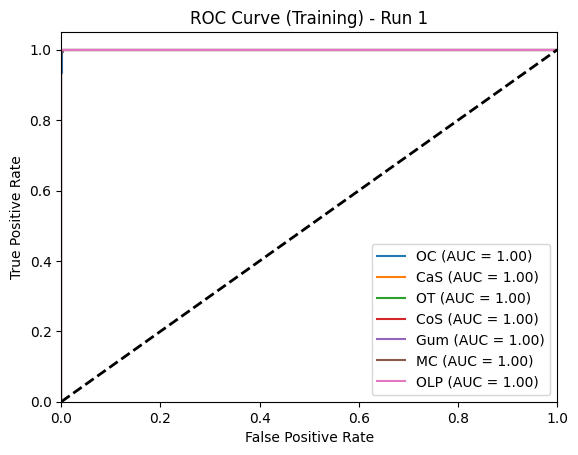

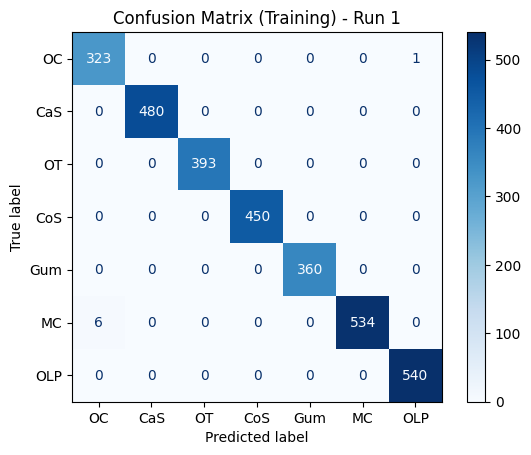

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        323       2757      6         1         
CaS       480       2607      0         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       360       2727      0         0         
MC        534       2547      0         6         
OLP       540       2546      1         0         


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 618ms/step

----------------------------- Testing Metrics for Run 1 ----------------------------------
Testing Time: 13.80 seconds
Accuracy: 97.276265%
Precision: 97.292205%
Recall: 97.276265%
F1 Score: 97.277743%


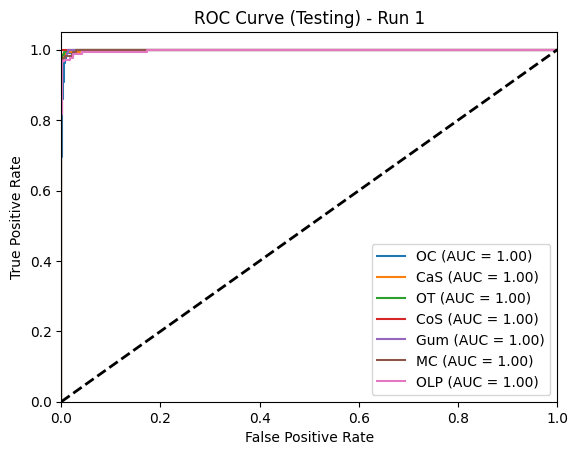

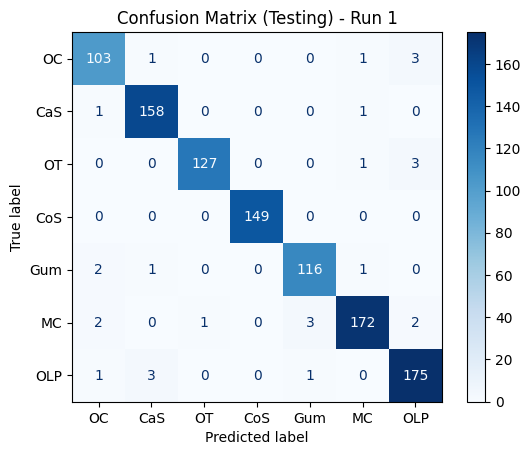

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        103       914       6         5         
CaS       158       863       5         2         
OT        127       896       1         4         
CoS       149       879       0         0         
Gum       116       904       4         4         
MC        172       844       4         8         
OLP       175       840       8         5         
Run 2/10

----------------------------- Training Metrics for Run 2 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.1950 - loss: 2.3199 - val_accuracy: 0.5545 - val_loss: 1.2535
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.5226 - loss: 1.3013 - val_accuracy: 0.6615 - val_loss: 0.8606
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.6719 - loss: 0.8497 - val_accuracy: 0.8482 - val_loss: 0.4943
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.8548 - los

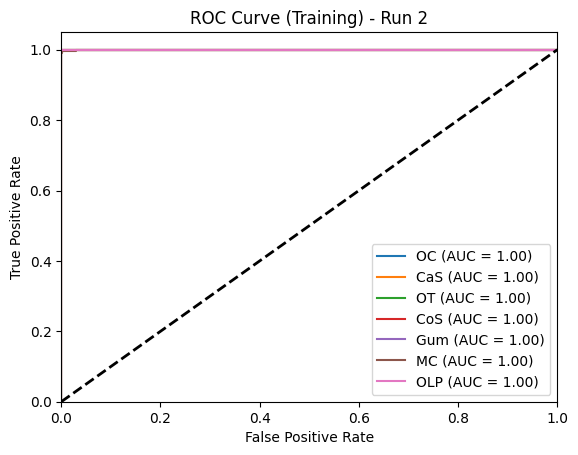

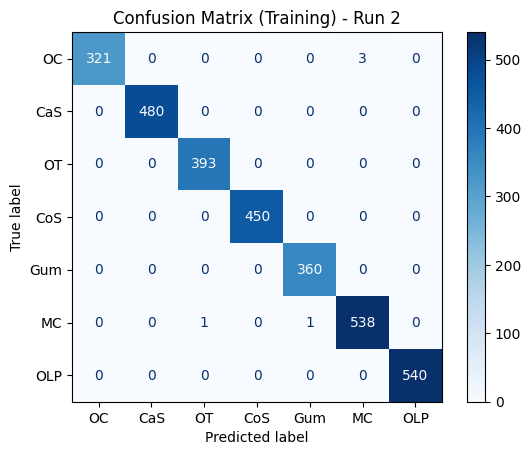

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        321       2763      0         3         
CaS       480       2607      0         0         
OT        393       2693      1         0         
CoS       450       2637      0         0         
Gum       360       2726      1         0         
MC        538       2544      3         2         
OLP       540       2547      0         0         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step

----------------------------- Testing Metrics for Run 2 ----------------------------------
Testing Time: 10.89 seconds
Accuracy: 97.568093%
Precision: 97.672797%
Recall: 97.568093%
F1 Score: 97.588523%


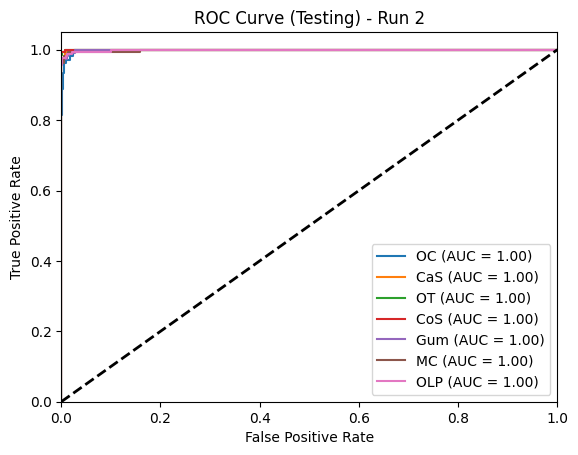

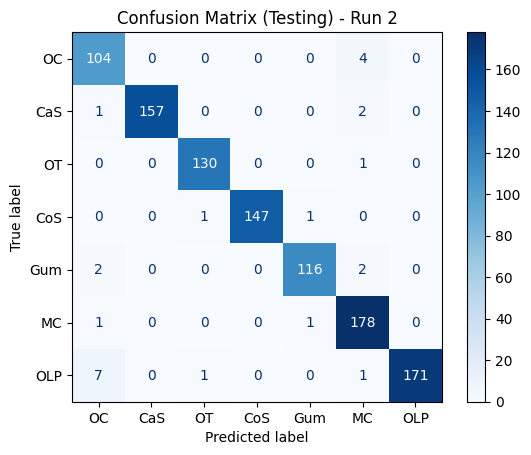

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        104       909       11        4         
CaS       157       868       0         3         
OT        130       895       2         1         
CoS       147       879       0         2         
Gum       116       906       2         4         
MC        178       838       10        2         
OLP       171       848       0         9         
Run 3/10

----------------------------- Training Metrics for Run 3 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.2658 - loss: 2.2099 - val_accuracy: 0.5564 - val_loss: 1.2510
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.5397 - loss: 1.3840 - val_accuracy: 0.7471 - val_loss: 0.8045
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - accuracy: 0.7785 - loss: 0.7135 - val_accuracy: 0.7568 - val_loss: 0.7656
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.8170 - los

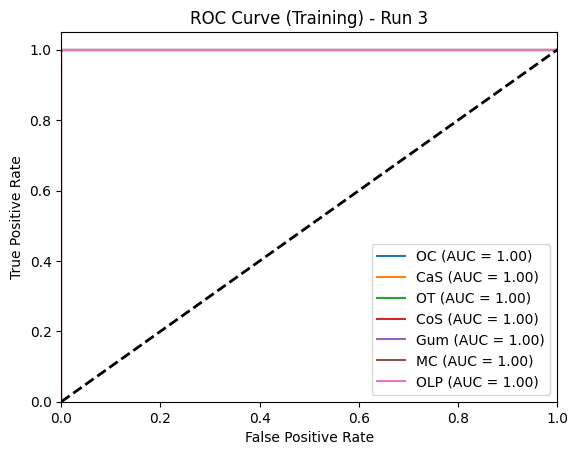

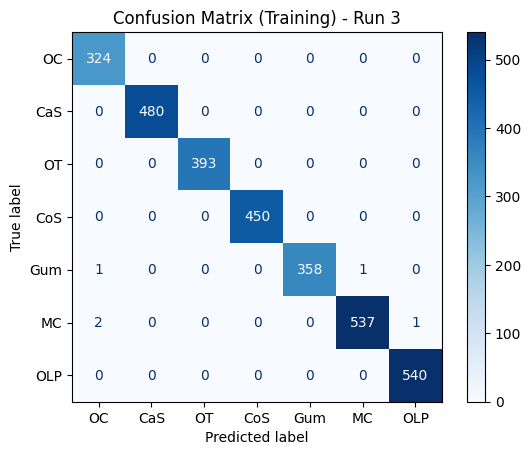

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        324       2760      3         0         
CaS       480       2607      0         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       358       2727      0         2         
MC        537       2546      1         3         
OLP       540       2546      1         0         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step

----------------------------- Testing Metrics for Run 3 ----------------------------------
Testing Time: 10.18 seconds
Accuracy: 98.151751%
Precision: 98.152774%
Recall: 98.151751%
F1 Score: 98.149677%


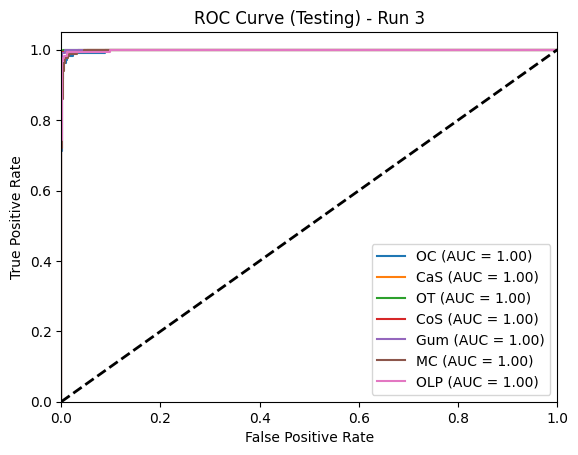

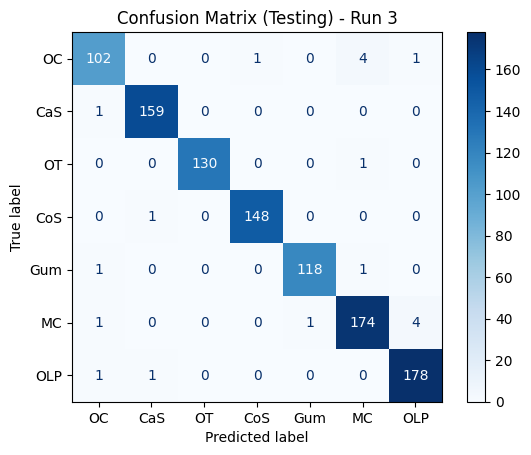

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        102       916       4         6         
CaS       159       866       2         1         
OT        130       897       0         1         
CoS       148       878       1         1         
Gum       118       907       1         2         
MC        174       842       6         6         
OLP       178       843       5         2         
Run 4/10

----------------------------- Training Metrics for Run 4 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.2495 - loss: 2.1437 - val_accuracy: 0.4757 - val_loss: 1.3216
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.5996 - loss: 1.1290 - val_accuracy: 0.5399 - val_loss: 1.1797
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.5611 - loss: 1.3181 - val_accuracy: 0.6780 - val_loss: 1.1561
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.7320 - los

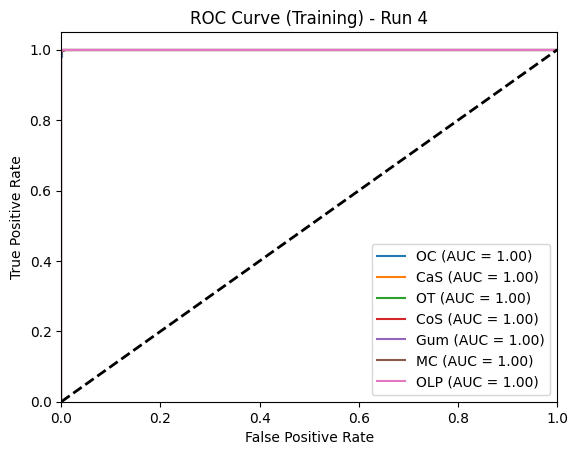

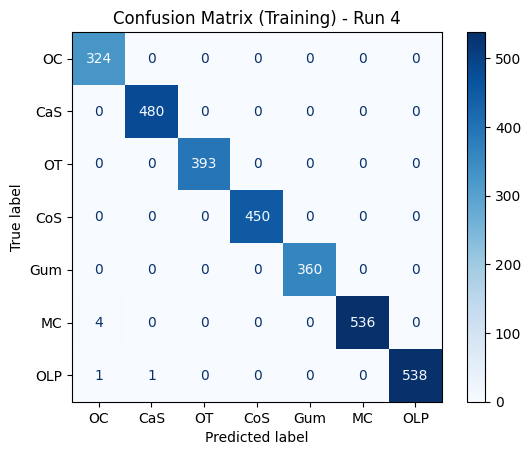

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        324       2758      5         0         
CaS       480       2606      1         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       360       2727      0         0         
MC        536       2547      0         4         
OLP       538       2547      0         2         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step

----------------------------- Testing Metrics for Run 4 ----------------------------------
Testing Time: 10.33 seconds
Accuracy: 96.789883%
Precision: 96.822247%
Recall: 96.789883%
F1 Score: 96.792855%


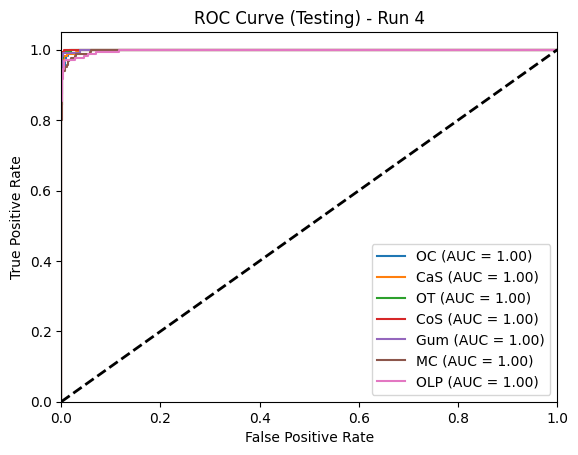

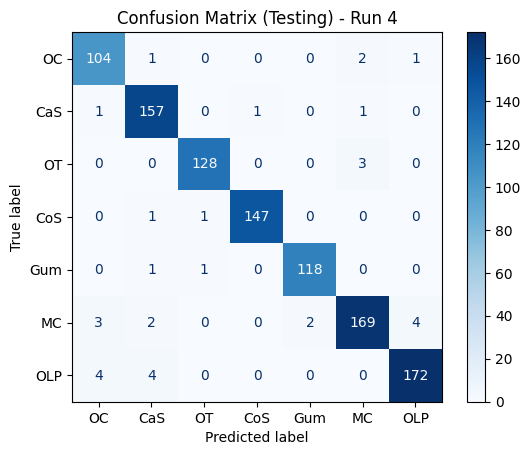

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        104       912       8         4         
CaS       157       859       9         3         
OT        128       895       2         3         
CoS       147       878       1         2         
Gum       118       906       2         2         
MC        169       842       6         11        
OLP       172       843       5         8         
Run 5/10

----------------------------- Training Metrics for Run 5 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.1766 - loss: 2.1876 - val_accuracy: 0.5613 - val_loss: 1.2012
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.5942 - loss: 1.1800 - val_accuracy: 0.7519 - val_loss: 0.7456
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.7993 - loss: 0.6309 - val_accuracy: 0.8084 - val_loss: 0.5307
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - accuracy: 0.8640 - los

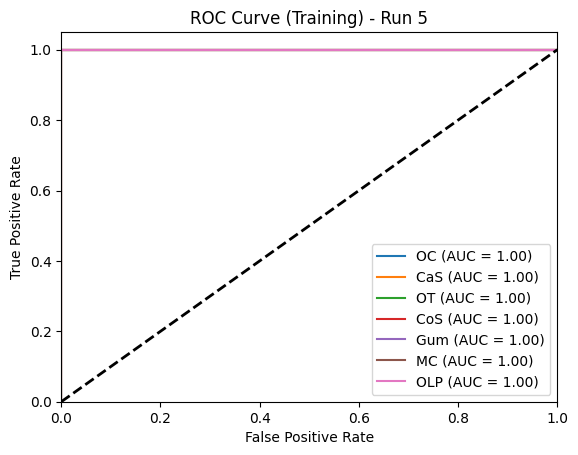

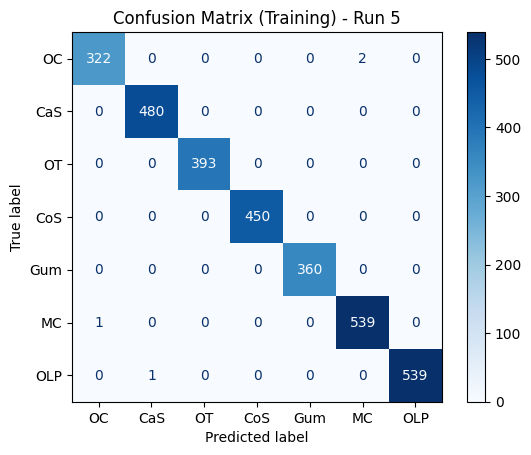

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        322       2762      1         2         
CaS       480       2606      1         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       360       2727      0         0         
MC        539       2545      2         1         
OLP       539       2547      0         1         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step

----------------------------- Testing Metrics for Run 5 ----------------------------------
Testing Time: 10.09 seconds
Accuracy: 97.957198%
Precision: 97.977398%
Recall: 97.957198%
F1 Score: 97.956699%


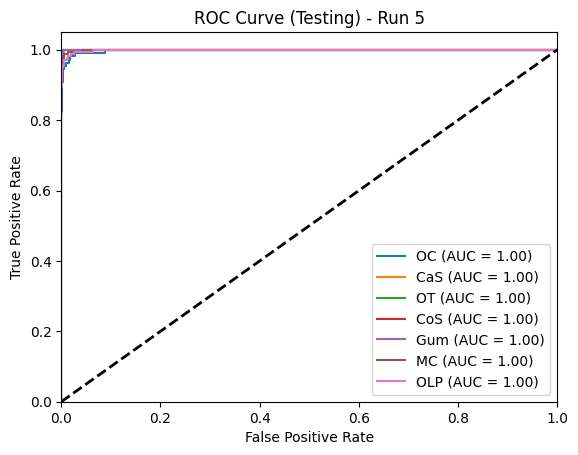

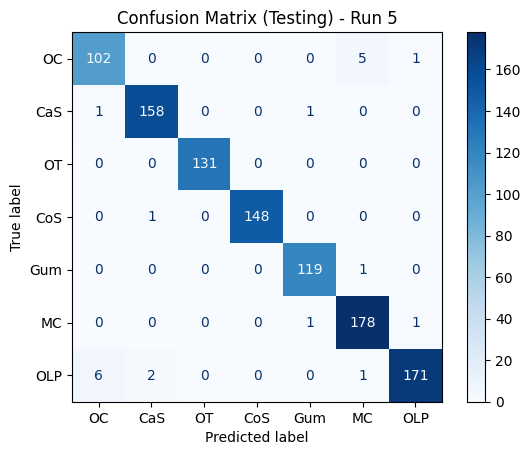

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        102       913       7         6         
CaS       158       865       3         2         
OT        131       897       0         0         
CoS       148       879       0         1         
Gum       119       906       2         1         
MC        178       841       7         2         
OLP       171       846       2         9         
Run 6/10

----------------------------- Training Metrics for Run 6 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.2285 - loss: 2.1352 - val_accuracy: 0.5584 - val_loss: 1.2036
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.5466 - loss: 1.2501 - val_accuracy: 0.7558 - val_loss: 0.7788
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.7666 - loss: 0.6860 - val_accuracy: 0.8074 - val_loss: 0.5940
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.8454 - los

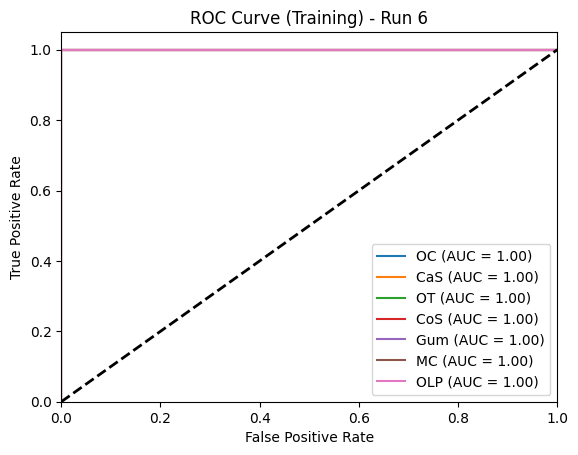

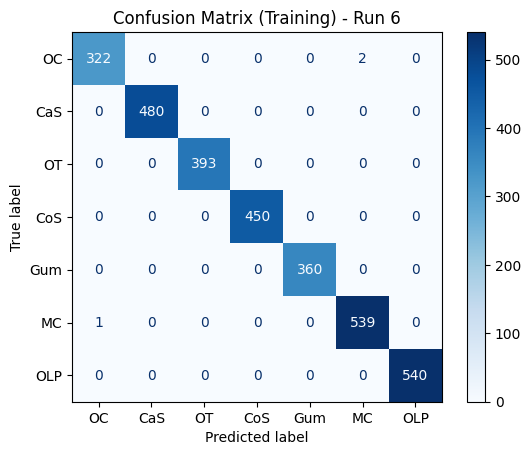

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        322       2762      1         2         
CaS       480       2607      0         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       360       2727      0         0         
MC        539       2545      2         1         
OLP       540       2547      0         0         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step

----------------------------- Testing Metrics for Run 6 ----------------------------------
Testing Time: 10.23 seconds
Accuracy: 97.859922%
Precision: 97.878448%
Recall: 97.859922%
F1 Score: 97.860909%


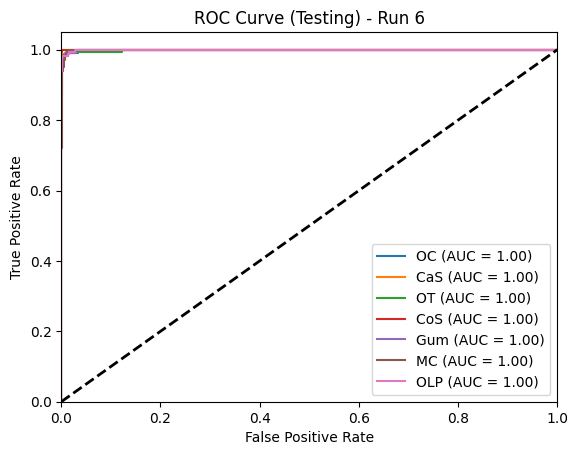

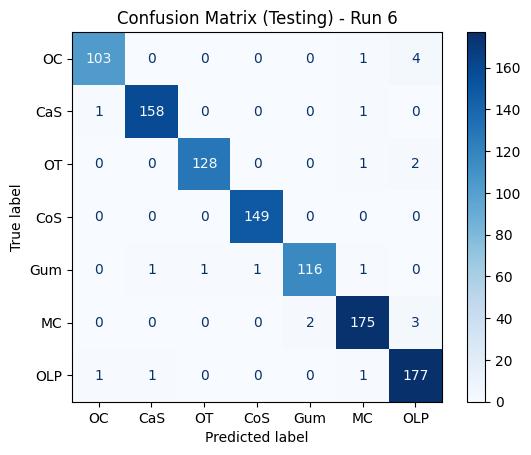

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        103       918       2         5         
CaS       158       866       2         2         
OT        128       896       1         3         
CoS       149       878       1         0         
Gum       116       906       2         4         
MC        175       843       5         5         
OLP       177       839       9         3         
Run 7/10

----------------------------- Training Metrics for Run 7 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.1913 - loss: 2.1082 - val_accuracy: 0.5953 - val_loss: 1.1818
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.5635 - loss: 1.2802 - val_accuracy: 0.7383 - val_loss: 0.8188
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.7056 - loss: 0.8901 - val_accuracy: 0.7335 - val_loss: 0.7326
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.7863 - los

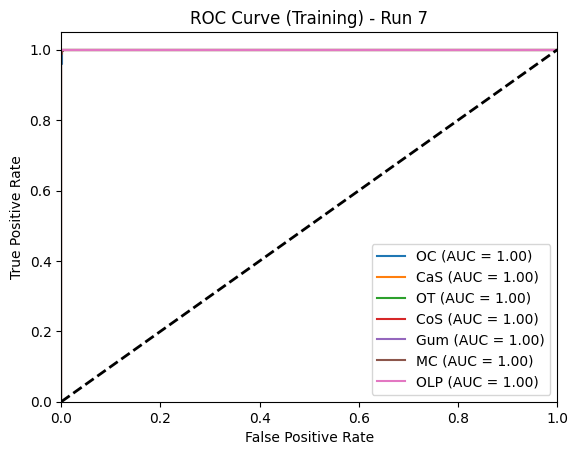

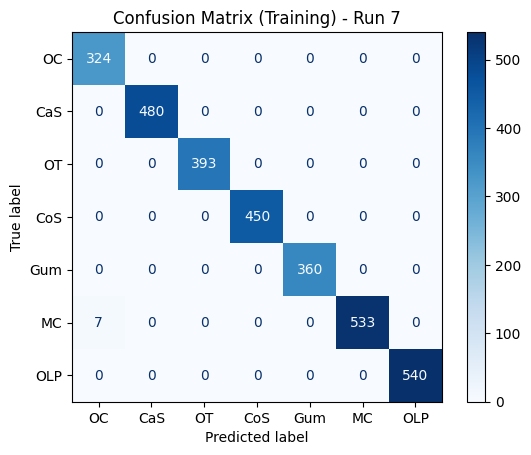

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        324       2756      7         0         
CaS       480       2607      0         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       360       2727      0         0         
MC        533       2547      0         7         
OLP       540       2547      0         0         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step

----------------------------- Testing Metrics for Run 7 ----------------------------------
Testing Time: 10.21 seconds
Accuracy: 97.470817%
Precision: 97.494498%
Recall: 97.470817%
F1 Score: 97.471660%


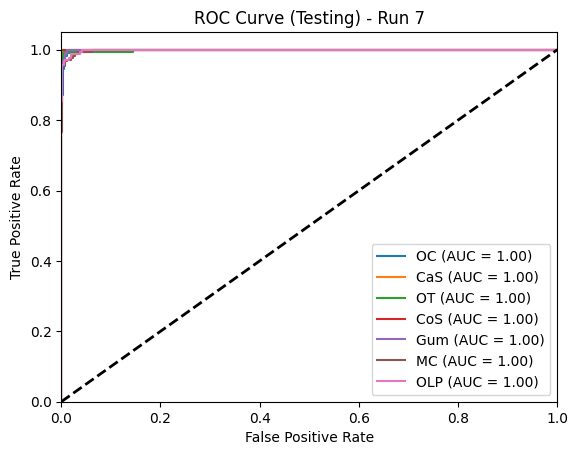

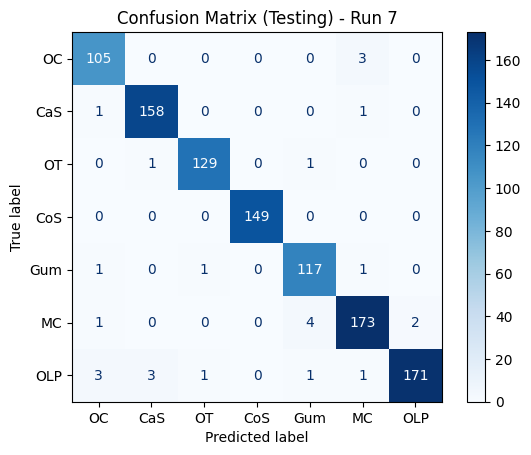

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        105       914       6         3         
CaS       158       864       4         2         
OT        129       895       2         2         
CoS       149       879       0         0         
Gum       117       902       6         3         
MC        173       842       6         7         
OLP       171       846       2         9         
Run 8/10

----------------------------- Training Metrics for Run 8 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.2350 - loss: 2.2759 - val_accuracy: 0.5243 - val_loss: 1.3022
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.5719 - loss: 1.1971 - val_accuracy: 0.4961 - val_loss: 1.4480
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.5787 - loss: 1.1722 - val_accuracy: 0.7558 - val_loss: 0.6375
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.8443 - los

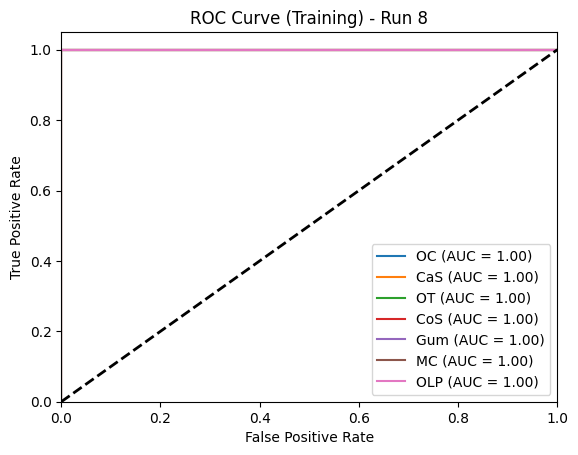

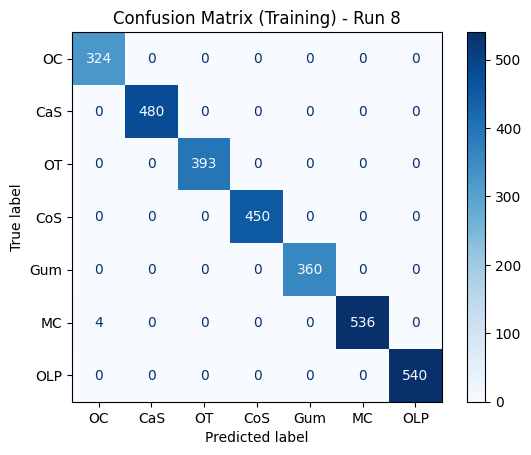

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        324       2759      4         0         
CaS       480       2607      0         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       360       2727      0         0         
MC        536       2547      0         4         
OLP       540       2547      0         0         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step

----------------------------- Testing Metrics for Run 8 ----------------------------------
Testing Time: 9.92 seconds
Accuracy: 97.568093%
Precision: 97.634950%
Recall: 97.568093%
F1 Score: 97.567947%


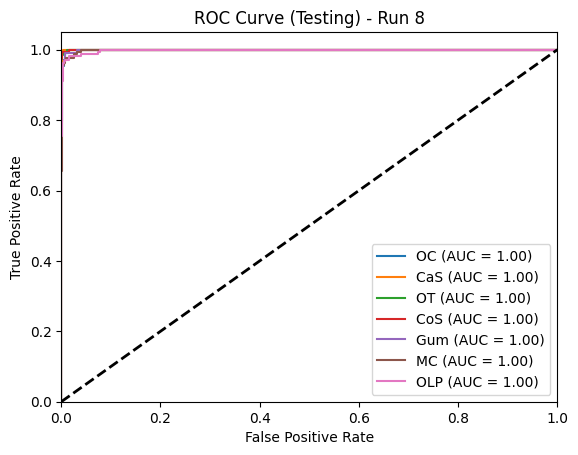

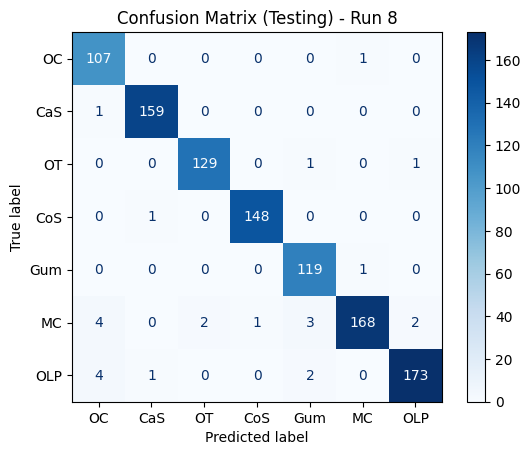

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        107       911       9         1         
CaS       159       866       2         1         
OT        129       895       2         2         
CoS       148       878       1         1         
Gum       119       902       6         1         
MC        168       846       2         12        
OLP       173       845       3         7         
Run 9/10

----------------------------- Training Metrics for Run 9 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.1415 - loss: 2.1861 - val_accuracy: 0.5817 - val_loss: 1.2956
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.5115 - loss: 1.3960 - val_accuracy: 0.7179 - val_loss: 0.8256
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.7423 - loss: 0.7341 - val_accuracy: 0.7743 - val_loss: 0.6769
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.8198 - los

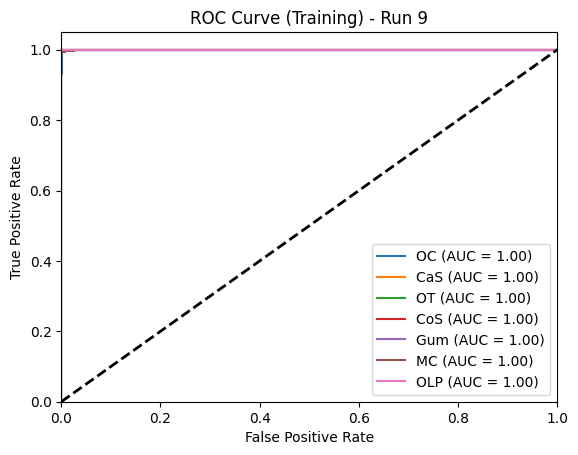

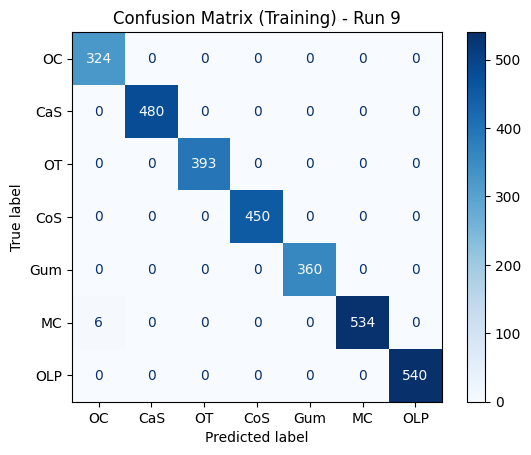

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        324       2757      6         0         
CaS       480       2607      0         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       360       2727      0         0         
MC        534       2547      0         6         
OLP       540       2547      0         0         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step

----------------------------- Testing Metrics for Run 9 ----------------------------------
Testing Time: 10.57 seconds
Accuracy: 97.276265%
Precision: 97.409281%
Recall: 97.276265%
F1 Score: 97.302131%


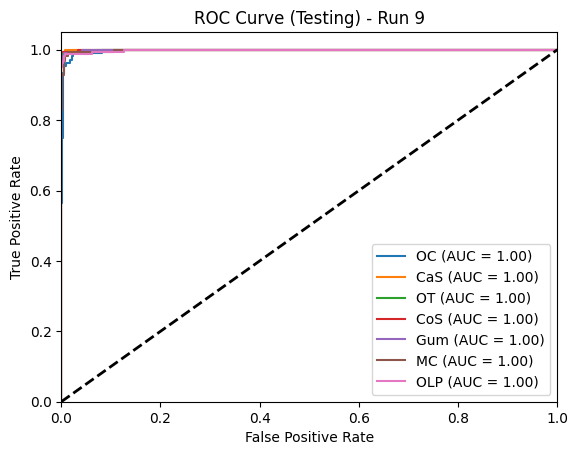

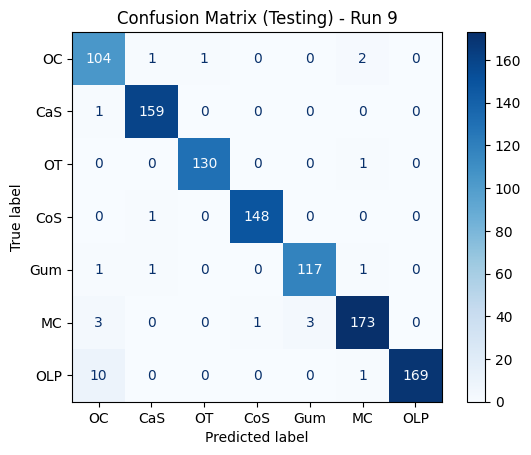

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        104       905       15        4         
CaS       159       865       3         1         
OT        130       896       1         1         
CoS       148       878       1         1         
Gum       117       905       3         3         
MC        173       843       5         7         
OLP       169       848       0         11        
Run 10/10

----------------------------- Training Metrics for Run 10 ----------------------------------
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.2840 - loss: 2.0739 - val_accuracy: 0.5749 - val_loss: 1.2378
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.6164 - loss: 1.1001 - val_accuracy: 0.5136 - val_loss: 1.5306
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - accuracy: 0.6714 - loss: 0.9307 - val_accuracy: 0.6683 - val_loss: 0.8961
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.7791 - l

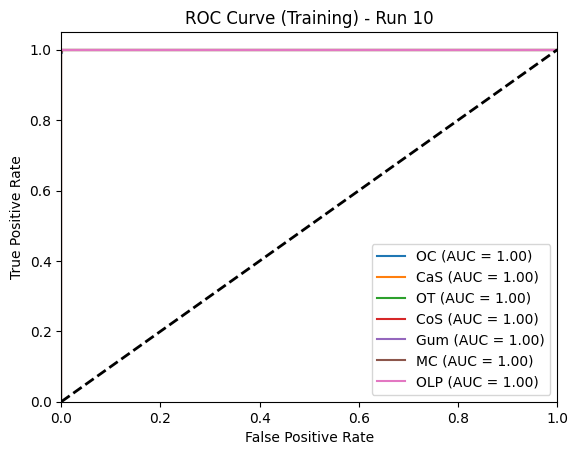

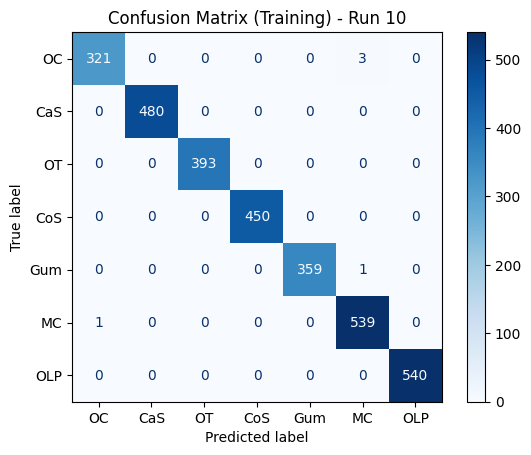

Confusion Matrix (Training):
Class     TP        TN        FP        FN        
OC        321       2762      1         3         
CaS       480       2607      0         0         
OT        393       2694      0         0         
CoS       450       2637      0         0         
Gum       359       2727      0         1         
MC        539       2543      4         1         
OLP       540       2547      0         0         
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step

----------------------------- Testing Metrics for Run 10 ----------------------------------
Testing Time: 10.06 seconds
Accuracy: 97.568093%
Precision: 97.571691%
Recall: 97.568093%
F1 Score: 97.568597%


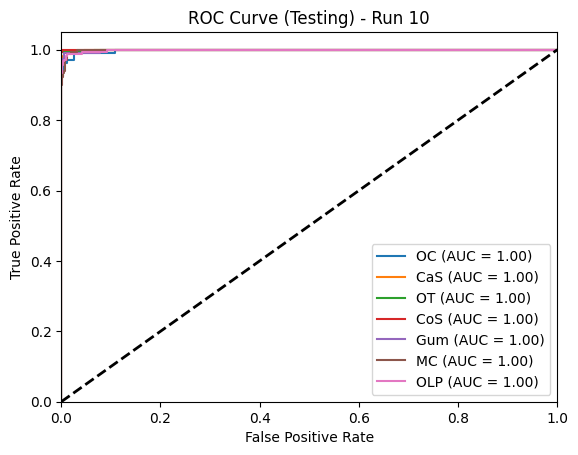

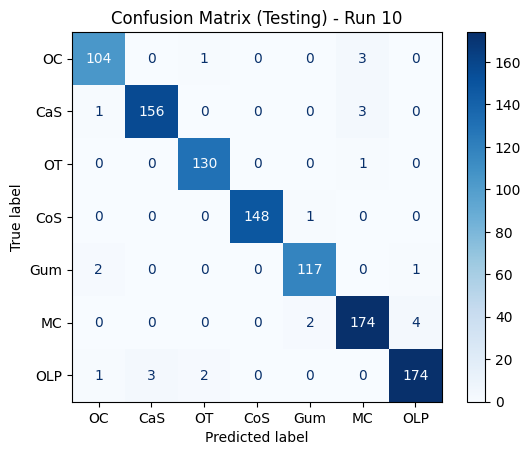

Confusion Matrix (Testing):
Class     TP        TN        FP        FN        
OC        104       916       4         4         
CaS       156       865       3         4         
OT        130       894       3         1         
CoS       148       879       0         1         
Gum       117       905       3         3         
MC        174       841       7         6         
OLP       174       843       5         6         

----------------------------- Average Metrics for Training ----------------------------------
Accuracy: 99.831552%
Precision: 99.833277%
Recall: 99.831552%
F1 Score: 99.831703%
Average Training Time: 279.92 seconds

Confusion Matrix (Averages for Training):
Class     TP        TN        FP        FN        
OC        322.9     2759.6    3.4       1.1       
CaS       480.0     2606.8    0.2       0.0       
OT        393.0     2693.9    0.1       0.0       
CoS       450.0     2637.0    0.0       0.0       
Gum       359.7     2726.9    0.1       0.3       

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf

def calculate_metrics(model, data_generator, phase):
    
    y_pred = model.predict(data_generator, steps=len(data_generator))

    # Collect true labels
    y_true = np.concatenate([data_generator[i][1] for i in range(len(data_generator))])
    
    # Convert to class predictions
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes) * 100
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted') * 100
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted') * 100
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted') * 100

    # Confusion matrix and stats
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    # ROC curve (one vs all)
#     y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return accuracy, precision, recall, f1, tp, tn, fp, fn, cm, fpr, tpr, roc_auc

def run_experiment(num_runs, num_epochs):
    # Initialize average metrics for training and testing
    avg_training_metrics = {
        'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0,
        'tp': np.zeros(num_classes), 'tn': np.zeros(num_classes),
        'fp': np.zeros(num_classes), 'fn': np.zeros(num_classes),
        'train_time': []
    }
    avg_testing_metrics = {
        'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0,
        'tp': np.zeros(num_classes), 'tn': np.zeros(num_classes),
        'fp': np.zeros(num_classes), 'fn': np.zeros(num_classes),
        'test_time': []
    }

    for run in range(num_runs):
        print(f'Run {run + 1}/{num_runs}')
        

        # Print training metrics for current run
        print(f"\n----------------------------- Training Metrics for Run {run + 1} ----------------------------------")
        
        # Training phase
        train_start = time.time()
        # Initialize and compile the model
        model,_ = train_model(base_model0, base_model1, num_classes)
        train_end = time.time()
        training_time = train_end - train_start
        avg_training_metrics['train_time'].append(training_time)
        
        # Calculate training metrics
        train_metrics = calculate_metrics(model, train_generator, phase="Training")

        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Accuracy: {train_metrics[0]:.6f}%")
        print(f"Precision: {train_metrics[1]:.6f}%")
        print(f"Recall: {train_metrics[2]:.6f}%")
        print(f"F1 Score: {train_metrics[3]:.6f}%")

        # Plot ROC curve for training
        fpr = train_metrics[9]
        tpr = train_metrics[10]
        roc_auc = train_metrics[11]
        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (Training) - Run {run + 1}')
        plt.legend(loc='lower right')
        plt.show()

        # Print confusion matrix for training
        cm = train_metrics[8]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix (Training) - Run {run + 1}')
        plt.show()
        
        print("Confusion Matrix (Training):")
        print(f"{'Class':<10}{'TP':<10}{'TN':<10}{'FP':<10}{'FN':<10}")
        for i in range(len(class_names)):
            print(f"{class_names[i]:<10}{train_metrics[4][i]:<10}{train_metrics[5][i]:<10}{train_metrics[6][i]:<10}{train_metrics[7][i]:<10}")

        # Store training metrics
        avg_training_metrics['accuracy'] += train_metrics[0]
        avg_training_metrics['precision'] += train_metrics[1]
        avg_training_metrics['recall'] += train_metrics[2]
        avg_training_metrics['f1'] += train_metrics[3]
        avg_training_metrics['tp'] += train_metrics[4]
        avg_training_metrics['tn'] += train_metrics[5]
        avg_training_metrics['fp'] += train_metrics[6]
        avg_training_metrics['fn'] += train_metrics[7]

        # Testing phase
        test_start = time.time()
        test_metrics = calculate_metrics(model, test_generator, phase="Testing")
        test_end = time.time()
        testing_time = test_end - test_start
        avg_testing_metrics['test_time'].append(testing_time)

        # Print testing metrics for current run
        print(f"\n----------------------------- Testing Metrics for Run {run + 1} ----------------------------------")
        print(f"Testing Time: {testing_time:.2f} seconds")
        print(f"Accuracy: {test_metrics[0]:.6f}%")
        print(f"Precision: {test_metrics[1]:.6f}%")
        print(f"Recall: {test_metrics[2]:.6f}%")
        print(f"F1 Score: {test_metrics[3]:.6f}%")

        # Plot ROC curve for testing
        fpr = test_metrics[9]
        tpr = test_metrics[10]
        roc_auc = test_metrics[11]
        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (Testing) - Run {run + 1}')
        plt.legend(loc='lower right')
        plt.show()

        # Print confusion matrix for testing
        cm = test_metrics[8]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix (Testing) - Run {run + 1}')
        plt.show()
        
        print("Confusion Matrix (Testing):")
        print(f"{'Class':<10}{'TP':<10}{'TN':<10}{'FP':<10}{'FN':<10}")
        for i in range(len(class_names)):
            print(f"{class_names[i]:<10}{test_metrics[4][i]:<10}{test_metrics[5][i]:<10}{test_metrics[6][i]:<10}{test_metrics[7][i]:<10}")

        # Store testing metrics
        avg_testing_metrics['accuracy'] += test_metrics[0]
        avg_testing_metrics['precision'] += test_metrics[1]
        avg_testing_metrics['recall'] += test_metrics[2]
        avg_testing_metrics['f1'] += test_metrics[3]
        avg_testing_metrics['tp'] += test_metrics[4]
        avg_testing_metrics['tn'] += test_metrics[5]
        avg_testing_metrics['fp'] += test_metrics[6]
        avg_testing_metrics['fn'] += test_metrics[7]

    # Calculate average metrics for training and testing
    for key in ['accuracy', 'precision', 'recall', 'f1']:
        avg_training_metrics[key] /= num_runs
        avg_testing_metrics[key] /= num_runs

    for key in ['tp', 'tn', 'fp', 'fn']:
        avg_training_metrics[key] /= num_runs
        avg_testing_metrics[key] /= num_runs

    avg_train_time = np.mean(avg_training_metrics['train_time'])
    avg_test_time = np.mean(avg_testing_metrics['test_time'])

    print("\n----------------------------- Average Metrics for Training ----------------------------------")
    print(f"Accuracy: {avg_training_metrics['accuracy']:.6f}%")
    print(f"Precision: {avg_training_metrics['precision']:.6f}%")
    print(f"Recall: {avg_training_metrics['recall']:.6f}%")
    print(f"F1 Score: {avg_training_metrics['f1']:.6f}%")
    print(f"Average Training Time: {avg_train_time:.2f} seconds")
    print("\nConfusion Matrix (Averages for Training):")
    print(f"{'Class':<10}{'TP':<10}{'TN':<10}{'FP':<10}{'FN':<10}")
    for i in range(len(class_names)):
        print(f"{class_names[i]:<10}{avg_training_metrics['tp'][i]:<10}{avg_training_metrics['tn'][i]:<10}{avg_training_metrics['fp'][i]:<10}{avg_training_metrics['fn'][i]:<10}")

    
    print("\n----------------------------- Average Metrics for Testing ----------------------------------")
    print(f"Accuracy: {avg_testing_metrics['accuracy']:.6f}%")
    print(f"Precision: {avg_testing_metrics['precision']:.6f}%")
    print(f"Recall: {avg_testing_metrics['recall']:.6f}%")
    print(f"F1 Score: {avg_testing_metrics['f1']:.6f}%")
    print(f"Average Testing Time: {avg_test_time:.2f} seconds")
    print("\nConfusion Matrix (Averages for Testing):")
    print(f"{'Class':<10}{'TP':<10}{'TN':<10}{'FP':<10}{'FN':<10}")
    for i in range(len(class_names)):
        print(f"{class_names[i]:<10}{avg_testing_metrics['tp'][i]:<10}{avg_testing_metrics['tn'][i]:<10}{avg_testing_metrics['fp'][i]:<10}{avg_testing_metrics['fn'][i]:<10}")
        
run_experiment(num_runs, num_epochs)